In [1]:
library(tidyverse)
library(wesanderson)
library(ggridges)
library(ggthemes)
library(reshape)
library(lme4)
library(coefplot2)
library(sjPlot)
source("../../../spydr_scripts/functions/get_os.R")

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘reshape’

The following object is masked from ‘package:dplyr’:

    rename

The following objects are masked from ‘package:tidyr’:

    expand, smiths

Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:reshape’:

    expand

The following object is masked from ‘package:tidyr’:

    expand

Loading required package: coda


In [2]:
os <- get_os()
if (os == 'linux'){home <- '/home/krista/'
} else if(os == 'osx'){home <- '/Users/67981492/'}

agg_data_path = paste0(home,'Dropbox/volatileValues/simple_rt_experiment_probabilityC/analysis/aggregated_data/')
setwd(agg_data_path)

In [3]:
clean_df <- read_csv('clean_df.csv',col_types = cols())
raw_df <- read_csv('raw_df_processed.csv',col_types = cols())
epoch_df <- read_csv('epoch_df.csv',col_types = cols())

(n_subjects = length(unique(clean_df$ID)))
(n_conditions = length(unique(clean_df$condition)))
n_clean_trials = 600

epoch_df <- epoch_df %>% group_by(ID, condition, epoch_n) %>% mutate(n_epoch_trials=max(epoch_trial))
epoch_df <- subset(epoch_df, n_epoch_trials >= 10 & epoch_trial <=10)

[1] 24

[1] 4

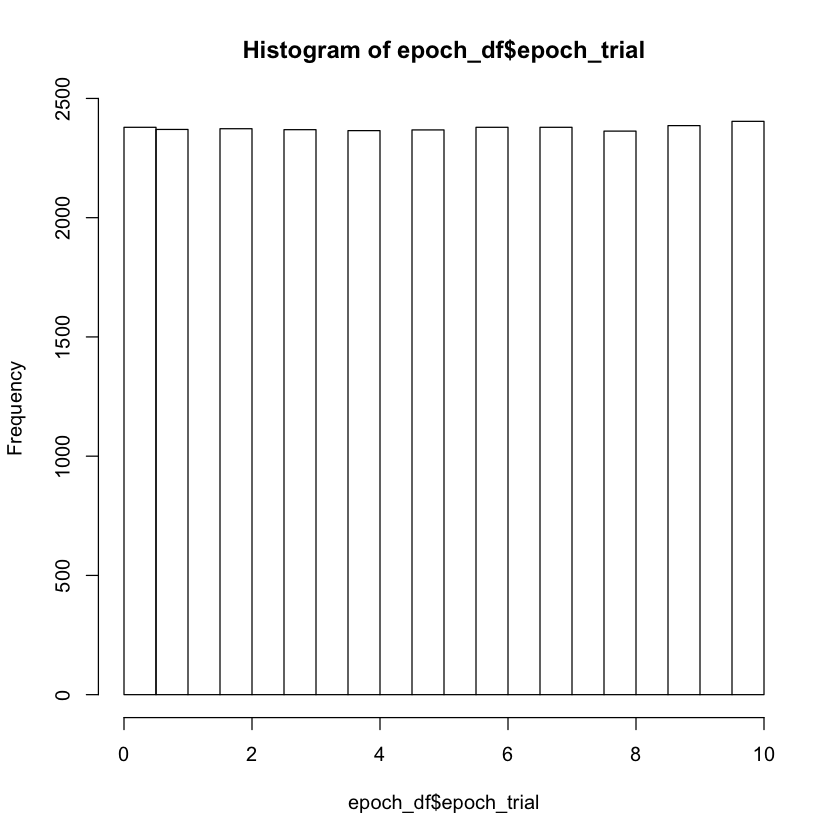

In [4]:
hist(epoch_df$epoch_trial)

In [5]:
names(epoch_df)
head(epoch_df)

[1] "LR_choice"             "obs_LR_accuracy"       "obs_LR_solution"      
 [4] "reward"                "cumulative_reward"     "rt"                   
 [7] "total_trial_time"      "iti"                   "cp_with_slow_fast"    
[10] "obs_cp_with_slow_fast" "obs_high_val_cue"      "ID"                   
[13] "condition"             "coded_condition"       "original_trial"       
[16] "epoch_n"               "epoch_trial"           "shifted_epoch_trial"  
[19] "max_epoch_n"           "repeat_trial"          "prop_112"             
[22] "n_epoch_trials"        "p_id_solution"         "obs_low_val_cue"      
[25] "id_choice"             "p_id_accuracy"         "ID_num"               
[28] "timepoint"             "conflict"              "vol"

LR_choice,obs_LR_accuracy,obs_LR_solution,reward,cumulative_reward,rt,total_trial_time,iti,cp_with_slow_fast,obs_cp_with_slow_fast,⋯,prop_112,n_epoch_trials,p_id_solution,obs_low_val_cue,id_choice,p_id_accuracy,ID_num,timepoint,conflict,vol
1,0,0,0,599,0.7115700,2.385458,0.6701990,1,0,⋯,0.3142857,10,111,111,111,1,761,1,high,mod
1,0,0,0,598,0.6814098,1.939019,0.2597073,0,1,⋯,0.3142857,10,111,112,112,0,761,1,high,mod
0,1,0,2,599,0.7671180,2.498060,0.7406146,0,0,⋯,0.3142857,10,111,112,111,1,761,1,high,mod
1,0,0,0,598,0.5072088,1.742433,0.2502416,0,0,⋯,0.3142857,10,111,112,112,0,761,1,high,mod
1,1,1,2,599,0.6562591,2.350417,0.7001898,0,0,⋯,0.3142857,10,111,112,111,1,761,1,high,mod
0,0,1,0,598,0.3423209,1.831150,0.4982311,0,1,⋯,0.3142857,10,111,111,111,1,761,1,high,mod


In [6]:
#separate dataframes for conflict & volatility 
head(epoch_df$condition)

epoch_df$conflict <- as.factor(epoch_df$conflict)
epoch_df$vol <- as.factor(epoch_df$vol)

#create distinct dfs
conflict_epoch_df <- subset(epoch_df, condition == 'hc' | condition == 'lc')
vol_epoch_df <- subset(epoch_df, condition == 'hv' | condition == 'lv')

[1] "hc" "hc" "hc" "hc" "hc" "hc"

In [7]:
#check subsetting
unique(vol_epoch_df$condition); unique(conflict_epoch_df$condition)

[1] "hv" "lv"

[1] "hc" "lc"


   0    1    2    3    4    5    6    7    8    9   10 
1269 1264 1266 1266 1260 1264 1269 1271 1259 1273 1283 

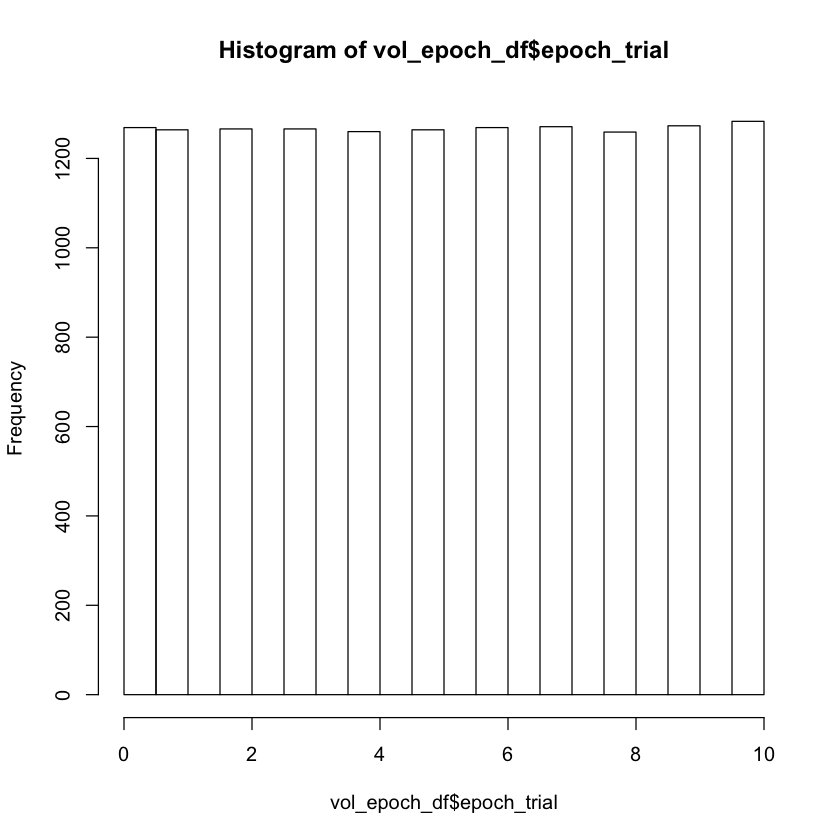

In [8]:
hist(vol_epoch_df$epoch_trial)
table(vol_epoch_df$epoch_trial)

In [9]:
#check that all epochs included had 10 or more trials per epoch
#so each epoch has 10 trials afer subsetting
#for fair analysis 
sum(epoch_df$n_epoch_trials >= 10) == nrow(epoch_df)

[1] TRUE

In [10]:
test <- epoch_df %>% group_by(ID, condition, epoch_n) %>% summarize(max(epoch_trial), max(n_epoch_trials))
sum(test[4] != 10)

[1] 0

## Win-stay win-switch
* if more volatile conditions rely more on previous outcomes, then probability of win-stay  should be higher, despite the target being less probably rewarding (lower expected value).

In [11]:
table(epoch_df$reward[epoch_df$reward == 0])
table(epoch_df$reward[epoch_df$reward > 0])


    0 
11973 


   1    2    3    4    5    6 
1924 5004 4990 1917  309   18 

In [12]:
#if observed accuracy is 1, then reward should be greater than 0 
#check if there are any zero-rewards
epoch_df[(epoch_df$obs_LR_accuracy > 0 & epoch_df$reward == 0), c('reward', 'original_trial', 'rt')]
#if observed accuracy is 0, then reward should also be 0
sum(epoch_df[epoch_df$obs_LR_accuracy == 0, 'reward'])

reward,original_trial,rt
0,494,0.3174210
0,213,0.5474498
0,317,0.2570019
0,362,0.3448889
0,540,0.3618262
0,334,0.1252439
0,386,0.3188620
0,417,0.3051770
0,425,0.3186760
0,189,0.2654479


[1] 0

In [13]:
#recalculate obs_accuracy to check for contradictions
obs_acc_test <- sum((epoch_df$LR_choice == epoch_df$obs_LR_solution) == epoch_df$obs_LR_accuracy) == nrow(epoch_df)
paste0('recalculated observed accuracy matches experimentally calculated observed accuracy: ', obs_acc_test)

[1] "recalculated observed accuracy matches experimentally calculated observed accuracy: TRUE"

In [14]:
#recalculate p_id_accuracy to check for contradictions
p_id_acc_test <- sum((epoch_df$id_choice == epoch_df$p_id_solution) == epoch_df$p_id_accuracy) == nrow(epoch_df)
paste0('recalculated accuracy in selecting target with highest expected value
matches previously calculated accuracy: ', p_id_acc_test)

[1] "recalculated accuracy in selecting target with highest expected value\nmatches previously calculated accuracy: TRUE"

if reward == 1, check id_choice. then check to see if that id is chosen on next trial. 

In [15]:
#find idx for trials which were & were not rewarded 
rewarded_trial_idx <- which(epoch_df$reward > 0)
unrewarded_trial_idx <- which(epoch_df$reward == 0)

In [16]:
rewarded_chosen_id <- epoch_df[rewarded_trial_idx, c('id_choice', 'ID', 'condition', 'epoch_n')]
unrewarded_chosen_id <- epoch_df[unrewarded_trial_idx, c('id_choice', 'ID', 'condition', 'epoch_n')]
colnames(rewarded_chosen_id)[1] = 'rewarded_id_choice'
colnames(unrewarded_chosen_id)[1] = 'unrewarded_id_choice'

In [17]:
#find next trial 
rewarded_next_t_idx <- rewarded_trial_idx + 1 
unrewarded_next_t_idx <- unrewarded_trial_idx + 1 

rewarded_next_t_chosen_id <- epoch_df[rewarded_next_t_idx, c('id_choice', 'ID', 'condition', 'epoch_n')]
unrewarded_next_t_chosen_id <- epoch_df[unrewarded_next_t_idx, c('id_choice', 'ID', 'condition', 'epoch_n')]

colnames(rewarded_next_t_chosen_id)[1] = 'rewarded_next_t_id_choice'
colnames(unrewarded_next_t_chosen_id)[1] = 'unrewarded_next_t_id_choice'

In [18]:
sum(rewarded_chosen_id$id_choice == rewarded_next_t_chosen_id$id_choice, na.rm=TRUE)/nrow(rewarded_chosen_id)
sum(unrewarded_chosen_id$id_choice == unrewarded_next_t_chosen_id$id_choice, na.rm=TRUE)/nrow(unrewarded_chosen_id)

Warning message:
“Unknown or uninitialised column: 'id_choice'.”Warning message:
“Unknown or uninitialised column: 'id_choice'.”

[1] 0

Warning message:
“Unknown or uninitialised column: 'id_choice'.”Warning message:
“Unknown or uninitialised column: 'id_choice'.”

[1] 0

In [19]:
rewarded_df <- merge(rewarded_chosen_id, rewarded_next_t_chosen_id)
unrewarded_df <- merge(unrewarded_chosen_id, unrewarded_next_t_chosen_id)
head(rewarded_df); head(unrewarded_df)

ID,condition,epoch_n,rewarded_id_choice,rewarded_next_t_id_choice
761,hc,1,111,112
761,hc,1,111,111
761,hc,1,111,112
761,hc,1,111,111
761,hc,1,112,112
761,hc,1,112,111


ID,condition,epoch_n,unrewarded_id_choice,unrewarded_next_t_id_choice
761,hc,1,112,111
761,hc,1,112,111
761,hc,1,112,112
761,hc,1,112,111
761,hc,1,112,112
761,hc,1,112,111


In [20]:
rewarded_df <-rewarded_df %>% 
group_by(ID, condition, epoch_n) %>% 
mutate(prop_stay = sum(rewarded_id_choice == rewarded_next_t_id_choice)/length(rewarded_id_choice), prop_shift = 1 - prop_stay)

In [21]:
head(rewarded_df)

ID,condition,epoch_n,rewarded_id_choice,rewarded_next_t_id_choice,prop_stay,prop_shift
761,hc,1,111,112,0.5,0.5
761,hc,1,111,111,0.5,0.5
761,hc,1,111,112,0.5,0.5
761,hc,1,111,111,0.5,0.5
761,hc,1,112,112,0.5,0.5
761,hc,1,112,111,0.5,0.5


In [22]:
rewarded_df %>% group_by(ID, condition) %>% summarize(mean(prop_stay))

ID,condition,mean(prop_stay)
761,hc,0.8320000
761,hv,0.8597046
761,lc,0.8417722
761,lv,0.8091922
762,hc,0.7364658
762,hv,0.7894144
762,lc,0.8539792
762,lv,0.7065949
763,hc,0.6755260
763,hv,0.5348339


In [23]:
table(epoch_df$epoch_trial, epoch_df$condition)

    
      hc  hv  lc  lv
  0  552 859 558 410
  1  550 853 556 411
  2  549 853 558 413
  3  547 854 556 412
  4  547 849 558 411
  5  551 850 553 414
  6  553 856 557 413
  7  552 857 556 414
  8  548 848 556 411
  9  552 859 561 414
  10 557 866 564 417

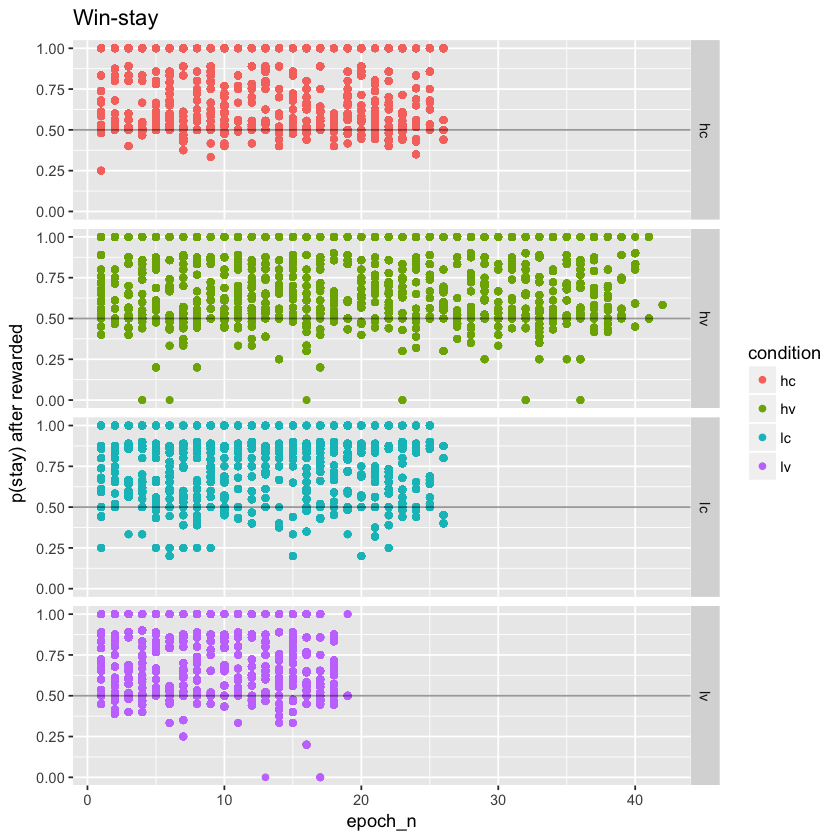

In [24]:
ggplot(rewarded_df, aes(epoch_n, prop_stay, col=condition)) + 
geom_point() + facet_grid(condition ~. ) + ylab('p(stay) after rewarded') + geom_hline(yintercept=0.5, alpha=0.4)  + ggtitle("Win-stay")

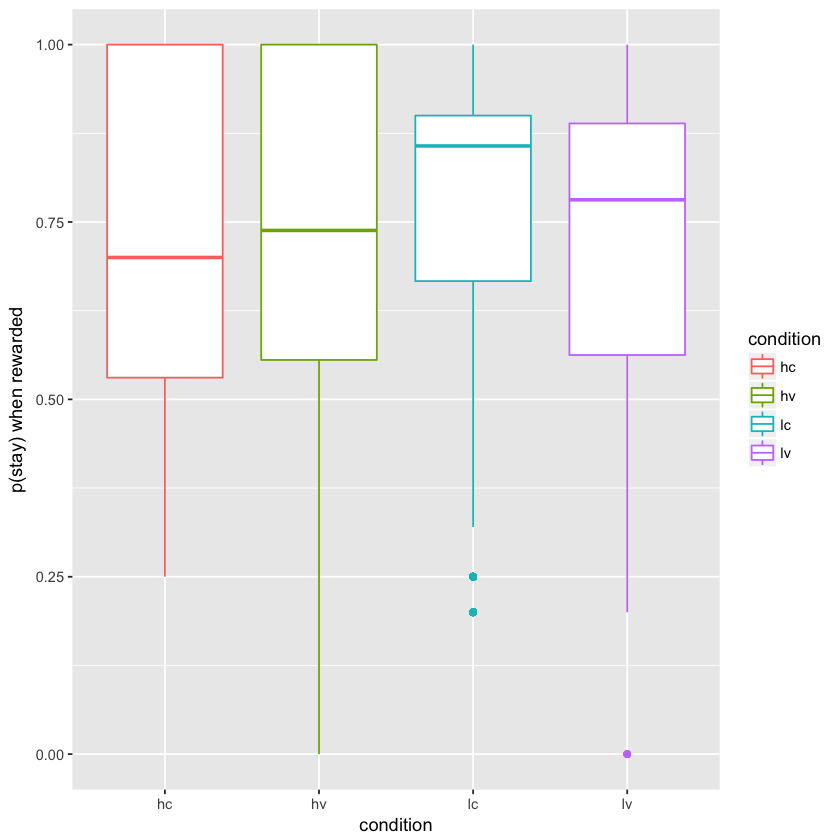

In [25]:
ggplot(rewarded_df, aes(condition, prop_stay, col=condition)) + geom_boxplot() + ylab("p(stay) when rewarded")

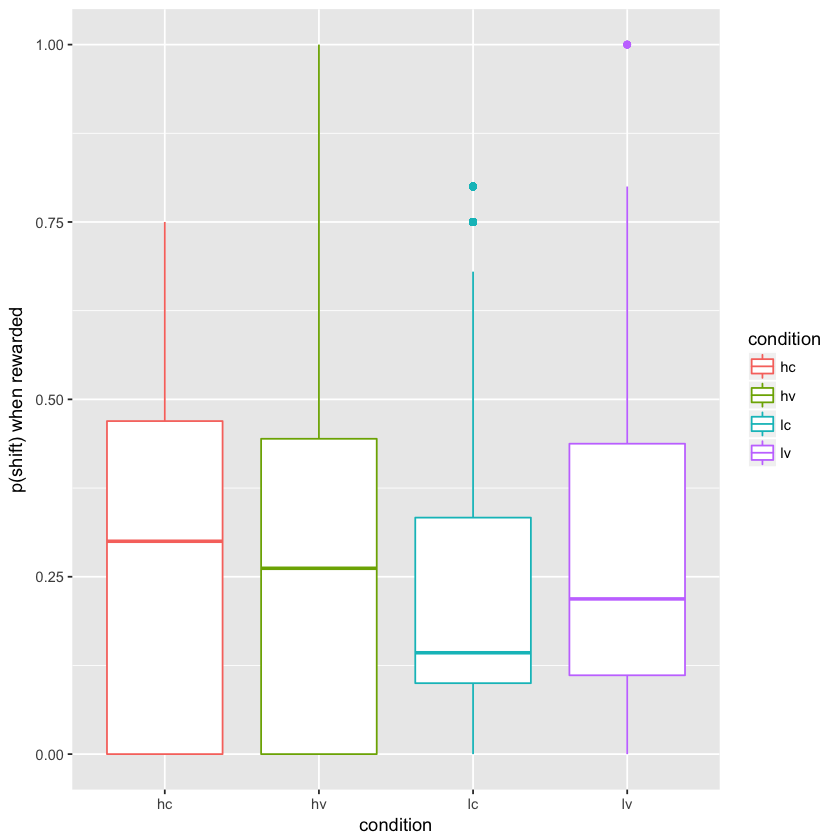

In [26]:
ggplot(rewarded_df, aes(condition, prop_shift, col=condition)) + geom_boxplot() + ylab("p(shift) when rewarded")

## Lost-shift &  lose-stay
* if more volatile conditions rely more on previous outcomes, then probability of lose-**shift** should be higher. For conflict conditions, lose-stay should be higher
in low conflict conditions than high conflict conditions, if true probabilities are learned.

In [27]:
unrewarded_df <-unrewarded_df %>% 
group_by(ID, condition, epoch_n) %>% 
mutate(prop_stay = sum(unrewarded_id_choice == unrewarded_next_t_id_choice)/length(unrewarded_id_choice), prop_shift = 1 - prop_stay)

In [28]:
unrewarded_df %>% group_by(ID, condition) %>% summarize(mean(prop_stay))

ID,condition,mean(prop_stay)
761,hc,0.6588072
761,hv,0.6100244
761,lc,0.5700935
761,lv,0.6674584
762,hc,0.5667190
762,hv,0.5138037
762,lc,0.4790576
762,lv,0.5398010
763,hc,0.6339066
763,hv,0.5343137


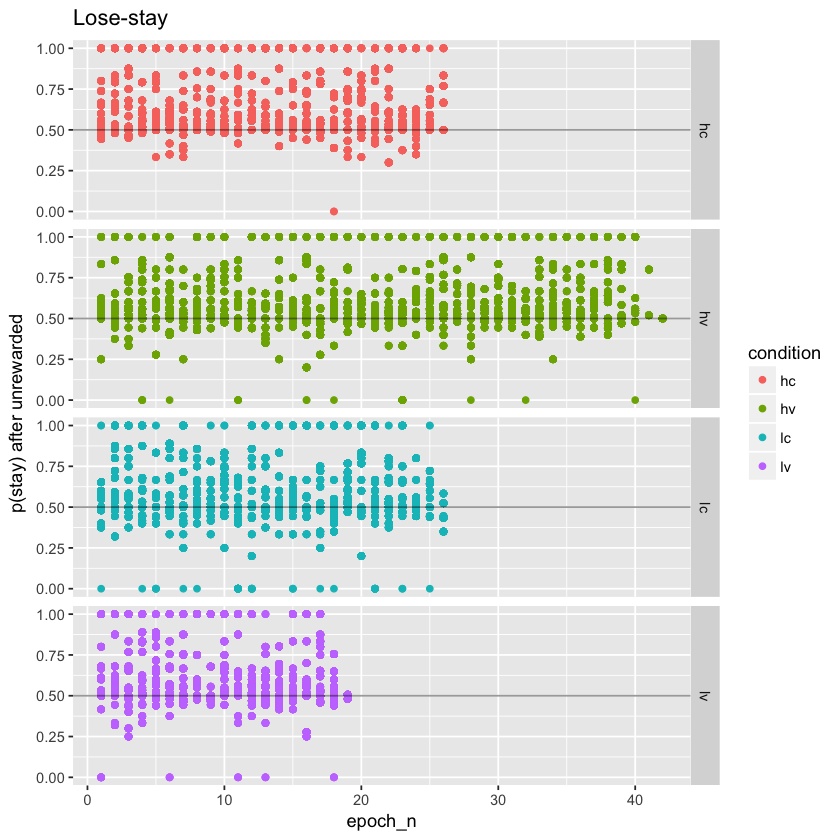

In [29]:
ggplot(unrewarded_df, aes(epoch_n, prop_stay, col=condition)) + 
geom_point() + facet_grid(condition ~. ) + ylab('p(stay) after unrewarded') +
geom_hline(yintercept=0.5, alpha=0.4) + ggtitle("Lose-stay")

In [30]:
# ggplot(unrewarded_df, aes(epoch_n, prop_shift, col=condition)) + 
# geom_point() + facet_grid(condition ~. ) + ylab('p(shift) after unrewarded') +
# geom_hline(yintercept=0.5, alpha=0.4)

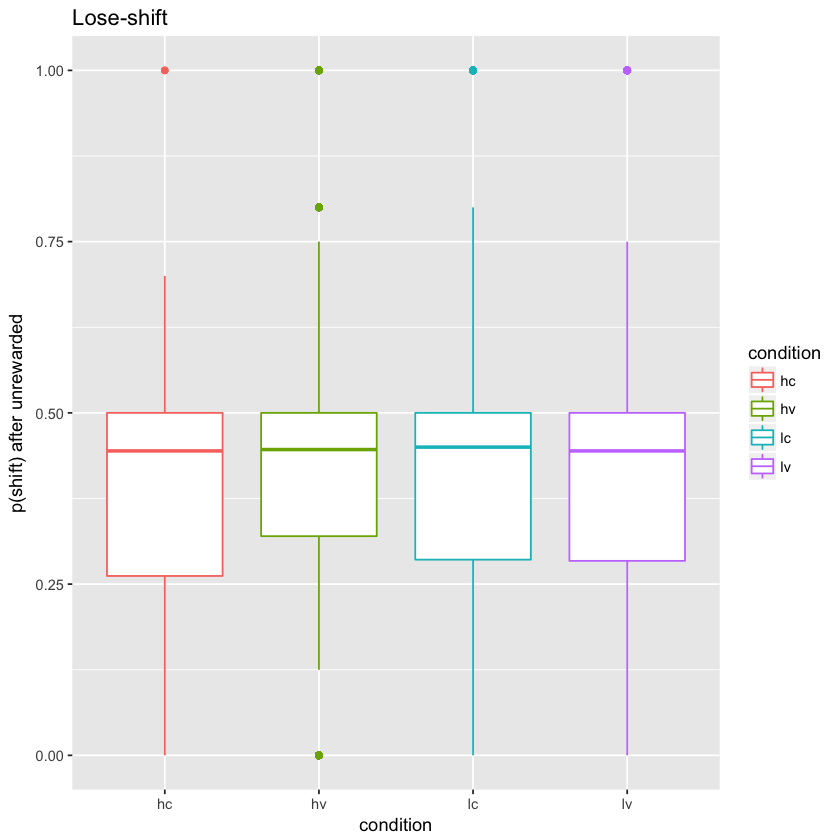

In [31]:
ggplot(unrewarded_df, aes(condition, prop_shift, col=condition)) + geom_boxplot() +  
ylab('p(shift) after unrewarded') + ggtitle('Lose-shift')

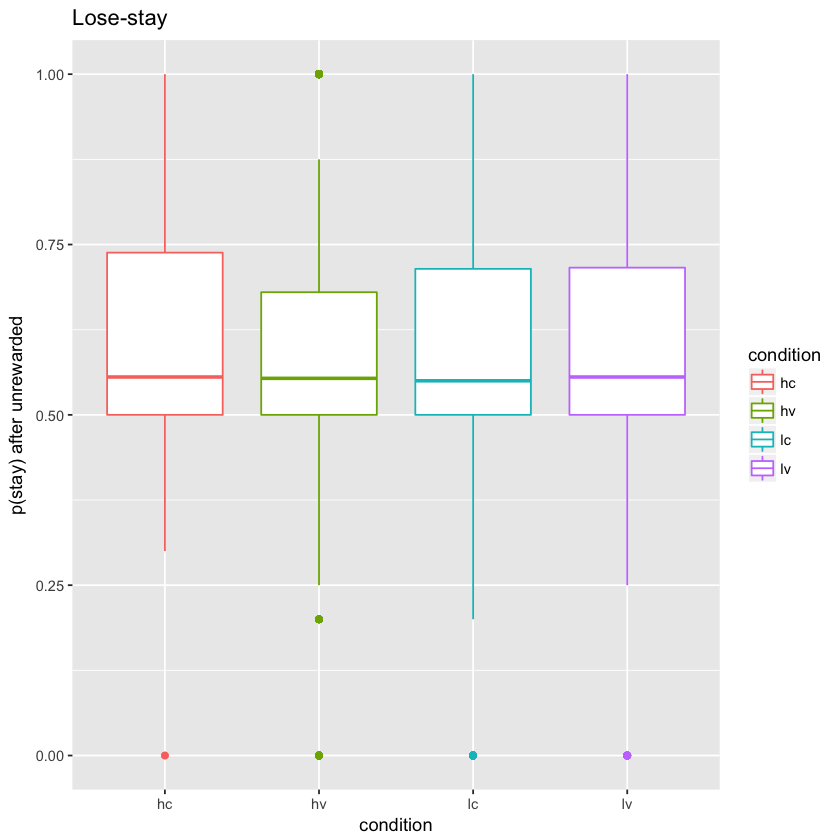

In [32]:
ggplot(unrewarded_df, aes(condition, prop_stay, col=condition)) + geom_boxplot() + 
ylab('p(stay) after unrewarded') + ggtitle('Lose-stay')

### Flaw in this analysis is that for the lc, lv, and hv conditions, the # of rewarded trials will be greater because they've better learned the probabilities. This presents a problem in estimating mean effects for lose-stay and lose-shift, and the relative proportion of rewarded & unrewarded trials will differ vastly by condition. 

In [33]:
unrewarded_df %>% group_by(condition) %>% count(condition)
#many more unrewarded trials for the hv condition. 

condition,n
hc,17755
hv,24582
lc,13176
lv,12206


In [34]:
rewarded_df %>% group_by(condition) %>% count(condition)
#many more rewarded trials for hv condition 

condition,n
hc,18424
hv,32445
lc,25305
lv,15604


In [35]:
epoch_df %>% group_by(condition) %>% tally(mean(p_id_accuracy))

condition,n
hc,0.5658633
hv,0.5919821
lc,0.6471547
lv,0.5764317


In [36]:
epoch_df %>% group_by(condition) %>% count(condition)

condition,n
hc,6058
hv,9404
lc,6133
lv,4540


In [37]:
600*4*24

[1] 57600

## Kyle's suggestion -- do an analysis on the individual level. Create some criterion of good/bad performers and redo. This could solve the statistical problem mentioned above (more rewarded than unrewarded trials, overall & difference in prop. of rewarded & unrewarded trials per condition)